# Gravity Fields Around Arbitrary Planets

My children designed a new planet in the shape of a cube, and then asked what would it be like to walk from one face to another. Would you look over a sheer cliff when you got to the edge, or would you experience something different? 

After visualising the gravity on the surface of a square planet, I wanted to do it better in numpy. I progressed through a few iterations of numpy meshgrid implementations, to also produce a 3D gravity field around a cube planet. Writing up as a handy reference.

# Visualisation

Defining a region of space by extent, with a square mass in the middle. Note you could create any arbitrarily-shaped mass, but we'll stick with square.

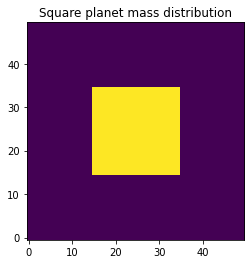

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

extent = 50
mass = np.zeros((extent, extent))

planet = 20
space = (extent - planet) // 2
b0 = space
b1 = planet + space
mass[b0:b1, b0:b1] = 1.0

plt.imshow(mass, origin='lower')
plt.title('Square planet mass distribution')
plt.show()

Calculate gravity vector at each point within the extents, by summing up the influence of all elements of mass within a region. This uses [Newton's Law of Universal Gravitation](https://en.wikipedia.org/wiki/Newton%27s_law_of_universal_gravitation) field equation, with the simplifying assumption that Gm1 = 1, and only calculating in empty space (not inside the planet).

In [2]:
def gravity_point_forloop(region, ip, jp):
  g = np.zeros(2)
  if region[ip, jp] == 0:
    p = np.array([ip, jp])
    for im in range(region.shape[0]):
      for jm in range(region.shape[1]):
        if im == ip and jm == jp or region[im, jm] == 0:
          continue
        dm = np.array([im, jm])    
        d = dm - p
        mag = region[im, jm] / np.dot(d, d)
        g = g + d * mag / np.linalg.norm(d)
  return g

def gravity_field_forloop(region):
  g = np.zeros((region.shape[0], region.shape[1], 2))
  for ip in range(region.shape[0]):
    for jp in range(region.shape[1]):
      g[ip, jp] = gravity_point_forloop(region, ip, jp)
  return g

In [3]:
%timeit gravity_field_forloop(mass)
G = gravity_field_forloop(mass)
strength = np.hypot(G[:,:,1], G[:,:,0])

1 loop, best of 3: 14.6 s per loop


And this is what it looks like in the region around the planet. It's pretty similar to a spherical planet once you move some distance from the surface. But we actually care about what's happening on the surface, and not just strength of gravity but direction.

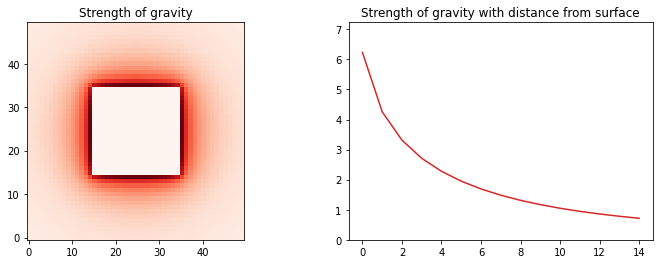

In [4]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)

ax[0].imshow(strength, origin='lower', cmap='Reds')
ax[0].set_title('Strength of gravity')

ax[1].plot(strength[extent//2, b1:], color='tab:red')
ax[1].set_ylim((0, max(strength[extent//2, :extent//2]) + 1))
ax[1].set_title('Strength of gravity with distance from surface')

plt.show()

Now, here's direction. Note that gravity at the edges points towards the centre of the planet. So you would not experience standing on a cliff, but rather a steep peak with 45 degree slopes. Let's zoom in further on the surface.

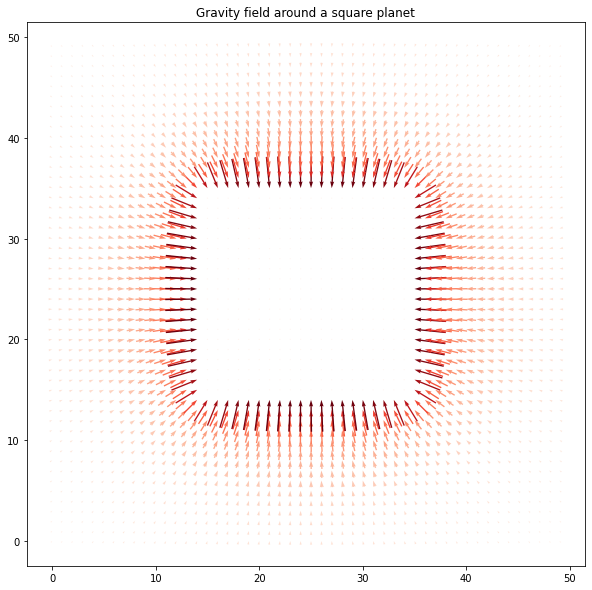

In [5]:
plt.figure(figsize=(10, 10))
plt.quiver(range(G.shape[0]), range(G.shape[1]), G[:,:,1], G[:,:,0], strength, cmap='Reds', pivot='tip')
plt.title('Gravity field around a square planet')
plt.show()

Now on the surface, we see that gravity is stronger in the middle of a face than on the edges. As above, gravity points straight into the middle of the face, and gradually changes direction to point 45 degrees to the surface at the edges. This would make the face feel like a 45 degree downslope on at one edge, flat in the middle, and 45 degree upslope at the other side, while still appearing totally straight to the eye! Wierd, and now I want to visit a cube planet!

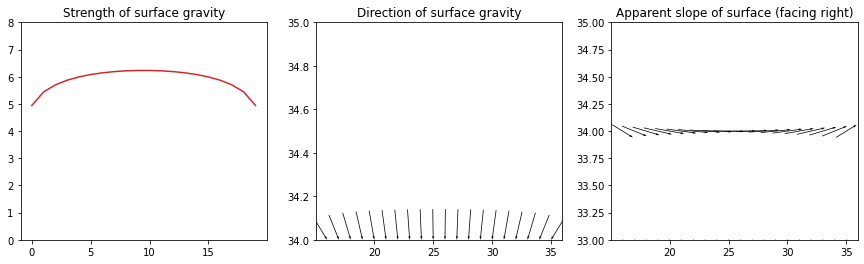

In [6]:
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)

ax[0].plot(strength[b0-1,b0:b1], color='tab:red')
ax[0].set_ylim((0, int(max(strength[b0-1,b0:b1])) + 2))
ax[0].set_title('Strength of surface gravity')

ax[1].quiver(range(b0+1,b1+1), range(b0,b1), G[b0+1:b1+1,b0:b1,1], G[b0+1:b1+1,b0:b1,0], scale=50, pivot='tip')
ax[1].set_ylim(b1 - 1, b1)
ax[1].set_title('Direction of surface gravity')

ax[2].quiver(range(b0+1,b1+1), range(b0,b1), -G[b0+1:b1+1,b0:b1,0], -G[b0+1:b1+1,b0:b1,1], scale=50, pivot='mid')
ax[2].set_ylim(b1 - 2, b1)
ax[2].set_title('Apparent slope of surface (facing right)')

plt.show()

# Numpy V1 - Coordinate Meshgrid



The for loop implementation is quite inefficient, and thinking ahead to 3D, I didn't want to nest 3 for loops, so I trialled a few different implementations in numpy.

This first version creates a numpy meshgrid from the coordinates of all elements of mass and all points for we wish to calculate the field. This constrains us to rectangular shapes.

## Start with 1D, distance calculation only

Starting simple to build up. First a 1D version that calculates the distance to every mass element, rather than the gravitational effect. These distances can then be summed per point in the field to simulate integrating the gravitational deltas.

In [7]:
# m prefix for mass elements
mpts_1d = 2
# n for "nodes" in the field
npts_1d = 2
xm = np.linspace(b0, b1, mpts_1d)
xn = np.linspace(0, extent, npts_1d)

xmg, xng = np.meshgrid(xm, xn)

def dist_1d(pm, pn):
  return np.abs(pm - pn)

Evelaute vector function for every combination of mass elements and field nodes.

In [8]:
dists_1d = dist_1d(xmg, xng)
dists_1d

array([[15., 35.],
       [35., 15.]])

Now total distance all mass elements at each field point.

In [9]:
tot_mass_dist_1d_by_node = np.apply_along_axis(sum, 1, dists_1d)
tot_mass_dist_1d_by_node

array([50., 50.])

## Add a 2nd dimension, distance calculation

This is a similar form with some additional array reshaping.

In [10]:
ym = xm.copy()
yn = xn.copy()

xmg, ymg, xng, yng = np.meshgrid(xm, ym, xn, yn)

def mhat_dist_2d(mx, my, nx, ny):
  return np.abs(mx - nx) + np.abs(my - ny)

In [11]:
dists_2d = mhat_dist_2d(xmg, ymg, xng, yng).T.reshape(len(xn) * len(yn), len(xm) * len(yn))
dists_2d

array([[30., 50., 50., 70.],
       [50., 70., 30., 50.],
       [50., 30., 70., 50.],
       [70., 50., 50., 30.]])

In [12]:
tot_mass_dist_2d_by_node = np.apply_along_axis(sum, 1, dists_2d)
tot_mass_dist_2d_by_node

array([200., 200., 200., 200.])

## Calculate gravity in 2D

Now introduce the gravity function in place of the distance function.

In [13]:
def dgrav_2dv1(xm, ym, xn, yn):
  dx = xm - xn
  dy = ym - yn
  r = np.hypot(dx, dy)
  d = np.array([dx, dy])
  return d / np.power(r, 3)

## Calculate Gravity Field

Note this is the same calculation as the for loop above, except it's much faster, and (conceptually at least) we reverse the order of summing the contribution of mass elements per node. We can produce the same field visualisation, but we need to mesh the nodes alone, as well as in combination with the mass elements.

In [14]:
mpts_2d = 20
npts_2d = 50
xm = np.linspace(b0, b1, mpts_2d)
ym = xm.copy()
xn = np.linspace(0, extent, npts_2d)
yn = xn.copy()

xmg, ymg, xng, yng = np.meshgrid(xm, ym, xn, yn)
xn2, yn2 = np.meshgrid(xn, yn)

%timeit np.apply_along_axis(sum, 1, dgrav_2dv1(xmg, ymg, xng, yng).T.reshape(len(xn) * len(yn), len(xm) * len(ym), 2))
G = np.apply_along_axis(sum, 1, dgrav_2dv1(xmg, ymg, xng, yng).T.reshape(len(xn) * len(yn), len(xm) * len(ym), 2))

1 loop, best of 3: 465 ms per loop


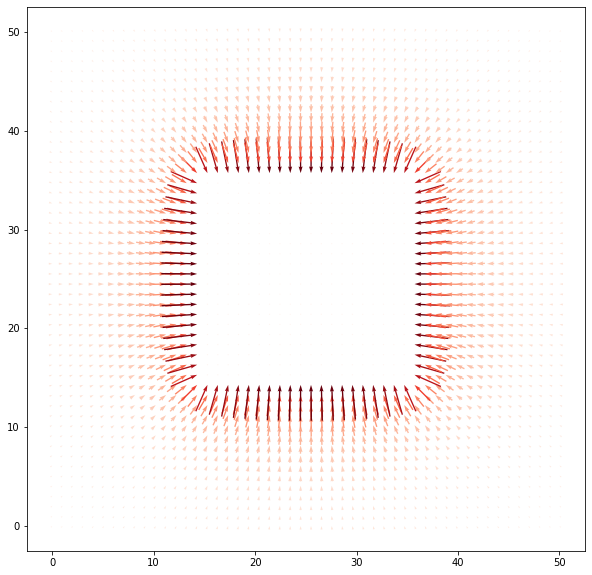

In [15]:
outer = (((xn2 < b0) | (xn2 > b1)) | ((yn2 < b0) | (yn2 > b1))).flatten()
gr_ext_x = G[:,0] * outer
gr_ext_y = G[:,1] * outer

plt.figure(figsize=(10, 10))
colours = np.hypot(gr_ext_x, gr_ext_y)
plt.quiver(xn2, yn2, gr_ext_x, gr_ext_y, colours, cmap='Reds', pivot='tip')
plt.show()

# Numpy V2 - Index Meshgrid

I prefer this version that creates 1D arrays of coordinates for mass elements and field nodes, and then creates a meshgrid of indexes into these arrays.

In [16]:
mpts_2d = 20
npts_2d = 50
xm = np.linspace(b0, b1, mpts_2d)
ym = xm.copy()
xn = np.linspace(0, extent, npts_2d)
yn = xn.copy()

In [17]:
xmg, ymg = np.meshgrid(xm, ym)
pmg = np.stack((xmg.flatten(), ymg.flatten()), axis=1)
xng, yng = np.meshgrid(xn, yn)
png = np.stack((xng.flatten(), yng.flatten()), axis=1)
pmg.shape, png.shape

((400, 2), (2500, 2))

In [18]:
mi = np.arange(len(pmg))
nj = np.arange(len(png))
mig, njg = np.meshgrid(mi, nj)
pmg[mig].shape, png[njg].shape

((2500, 400, 2), (2500, 400, 2))

In [19]:
def dgrav_2dv2(pm, pn):
  d = pm - pn
  r = np.hypot(d[:,:,0], d[:,:,1])
  return d / np.power(r, 3).reshape(npts_2d ** 2, mpts_2d ** 2, 1)

Execution time is very similar

In [20]:
%timeit np.apply_along_axis(sum, 1, dgrav_2dv2(pmg[mig], png[njg]))
G = np.apply_along_axis(sum, 1, dgrav_2dv2(pmg[mig], png[njg]))

1 loop, best of 3: 472 ms per loop


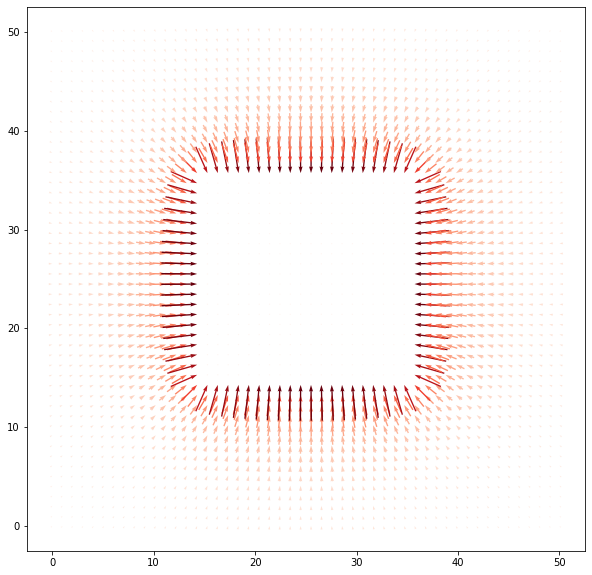

In [21]:
outer = (((xng < b0) | (xng > b1)) | ((yng < b0) | (yng > b1))).flatten()
gr_ext_x = G[:,0] * outer
gr_ext_y = G[:,1] * outer

plt.figure(figsize=(10, 10))
colours = np.hypot(gr_ext_x, gr_ext_y)
plt.quiver(xng, yng, gr_ext_x, gr_ext_y, colours, cmap='Reds', pivot='tip')
plt.show()

# Gravity in 3D

Now we can extend the V2 formulation to 3D calculations and visualisation. For ease of visualisation, we reduce the extent around the planet.

In [22]:
mpts_3d = 20
npts_3d = 10
margin = 1
xm = np.linspace(b0, b1, mpts_3d)
ym = xm.copy()
zm = xm.copy()
xn = np.linspace(b0 - margin, b1 + margin, npts_3d)
yn = xn.copy()
zn = xn.copy()

In [23]:
xmg, ymg, zmg = np.meshgrid(xm, ym, zm)
pmg = np.stack((xmg.flatten(), ymg.flatten(), zmg.flatten()), axis=1)
xng, yng, zng = np.meshgrid(xn, yn, zn)
png = np.stack((xng.flatten(), yng.flatten(), zng.flatten()), axis=1)
pmg.shape, png.shape

((8000, 3), (1000, 3))

In [24]:
mi = np.arange(len(pmg))
nj = np.arange(len(png))
mig, njg = np.meshgrid(mi, nj)
pmg[mig].shape, png[njg].shape

((1000, 8000, 3), (1000, 8000, 3))

In [25]:
def dgrav_3d(pm, pn):
  d = pm - pn
  r = np.hypot(np.hypot(d[:,:,0], d[:,:,1]), d[:,:,2])
  dg = d / np.power(r, 3).reshape(npts_3d ** 3, mpts_3d ** 3, 1)
  return dg

In [26]:
%timeit np.apply_along_axis(sum, 1, dgrav_3d(pmg[mig], png[njg]))
G = np.apply_along_axis(sum, 1, dgrav_3d(pmg[mig], png[njg])).reshape(npts_3d, npts_3d, npts_3d, 3)

1 loop, best of 3: 4.95 s per loop


In [27]:
outer = (((xng < b0) | (xng > b1)) | ((yng < b0) | (yng > b1)) | ((zng < b0) | (zng > b1)))
gr_ext_x = G[:,:,:,0] * outer
gr_ext_y = G[:,:,:,1] * outer
gr_ext_z = G[:,:,:,2] * outer
colours = np.hypot(np.hypot(gr_ext_x, gr_ext_y), gr_ext_z)

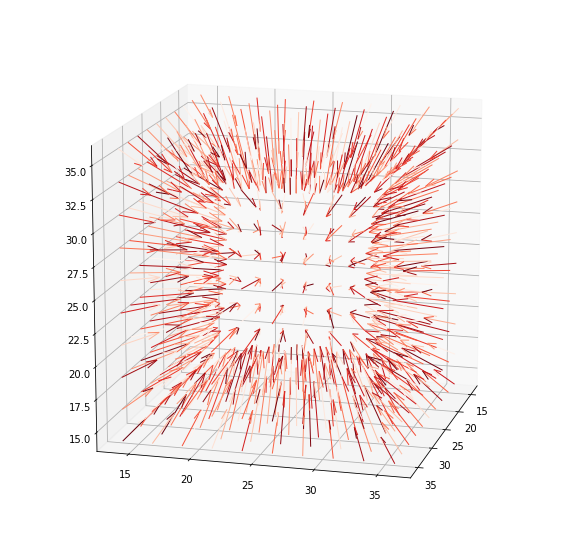

In [28]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
q = ax.quiver(xng, yng, zng, gr_ext_x, gr_ext_y, gr_ext_z, colours, length=0.1, cmap='Reds', lw=1)
q.set_array(np.random.rand(np.prod(xng.shape)))

ax.view_init(15, 15)
plt.show()